In [20]:
from sklearn import tree, linear_model, ensemble
from xgboost import XGBClassifier  

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 导入训练集

In [42]:
rsp_list = []
path_RSP = '../../RSP数据块/'
RSP_name = os.listdir(path_RSP)
rsp1 = pd.read_csv(os.path.join( path_RSP, RSP_name[0]))
rsp2 = pd.read_csv(os.path.join( path_RSP, RSP_name[1]))
rsp_ = pd.concat([rsp1, rsp2]).reset_index(drop=True)
rsp_

,label,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.493210,0.866778,-0.830316,2.571520,-0.279262,0.809716,0.387154,1.601197,0.000000,...,-0.314435,1.122981,0.000000,0.597446,0.763127,0.987707,1.534347,0.829040,1.518393,1.263348
1,0.0,0.655356,0.731396,0.241781,3.067170,-0.474623,2.183550,1.168446,0.791809,0.000000,...,0.449264,-1.371455,3.101961,0.619959,0.563526,1.180472,0.719782,0.591422,0.671538,0.645881
2,1.0,0.593681,0.027217,1.743236,1.053611,0.763017,0.723880,-1.656680,-1.571044,0.000000,...,0.505896,0.130798,3.101961,0.833194,0.999375,0.981343,1.028082,0.869200,0.936227,0.969262
3,0.0,1.616885,-1.265240,-0.433588,0.528759,1.540286,0.923767,-0.240651,1.256375,2.173076,...,-1.889304,0.005943,0.000000,0.815824,1.041715,1.253270,1.269991,0.848547,0.940010,0.884574
4,1.0,1.080669,0.221037,1.049104,1.071846,1.363433,1.124387,0.970400,1.130532,2.173076,...,0.775731,-0.477488,0.000000,1.198861,0.985718,0.978730,1.124434,1.690711,1.168876,1.109496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307995,0.0,2.736718,-0.110113,-1.299174,0.089312,-0.684843,1.334900,0.479246,-0.159047,1.086538,...,0.314346,0.618565,0.000000,0.538324,0.777602,0.990218,1.462012,1.727489,1.157127,1.057665
307996,0.0,0.779436,-1.271083,-1.011756,1.956299,-1.555708,0.797807,-0.070332,0.210823,2.173076,...,-0.087074,-0.175061,3.101961,0.778095,0.830611,0.985546,0.875963,0.312580,0.902586,0.927676
307997,1.0,0.586361,1.229095,-1.616000,2.062882,-0.774793,1.276638,1.343717,0.565624,0.000000,...,0.250219,-1.398090,3.101961,1.198142,1.030663,1.048485,0.966321,0.512713,0.742524,0.847971
307998,0.0,0.501262,-2.220703,-1.690351,1.760279,-1.240892,0.892254,-0.426815,0.142635,0.000000,...,1.083875,-1.405304,0.000000,0.929503,1.038415,0.994763,0.861179,0.216480,1.112128,1.127697


观察

## 导入测试集

In [3]:
path_test = 'C:/Users/86135/Desktop/大数据处理大作业/test.csv'
data_test = pd.read_csv(path_test)

## 数据分割与处理

In [43]:
def data_preprocess(rsp):
    # 类别分布
    print('label = 1 : ', int(rsp['label'].sum()))
    print('label = 0 : ', int(rsp.shape[0] - rsp['label'].sum()))
    # 计算sample_weight，这个特征起到欠/过采样的作用
    total_ = rsp.shape[0]
    pos = int(rsp['label'].sum())
    neg = int(rsp.shape[0] - rsp1['label'].sum())
    weight_for_1 = (1/pos)*(total_)/2.0
    weight_for_0 = (1/neg)*(total_)/2.0
    print('weight_for_0: ', weight_for_0)
    print('weight_for_1: ', weight_for_1)
    # 添加weight特征
    rsp['weight'] = rsp['label'].apply(lambda x : weight_for_0 if x==0.0 else weight_for_1)
    X_rsp = rsp.drop(['label', 'weight'], axis=1)
    y_rsp = rsp['label']
    W_rsp = rsp['weight'].values
    return (X_rsp, y_rsp, W_rsp)

In [44]:
X_rsp, y_rsp, W_rsp = data_preprocess(rsp_)

label = 1 :  163116
label = 0 :  144884
weight_for_0:  0.6799086979748433
weight_for_1:  0.9441133916967066


降维可视化数据

In [7]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 

def plot_pca(num, data, label):
    '''
    PCA降维可视化函数，可降至3维、2维
    @parma: num 维度
    @parma: data 样本数据（标准化之后?）
    @parma: label 样本标签（正常值，异常值）
    '''
    pca=PCA(n_components=num)
    X_pca=pca.fit_transform(data)
    # print(pca.components_)
    # 分割数据
    X_failure=np.array([x for i,x in enumerate(X_pca) if label[i]==1])
    X_healthy=np.array([x for i,x in enumerate(X_pca) if label[i]==0])
    
    if num==3:
        fig = plt.figure(figsize=[10,15])
        ax = Axes3D(fig)   
        #ax.legend(loc='best')
        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        ax.scatter(X_failure[:,0], X_failure[:,1], X_failure[:,2])
        ax.scatter(X_healthy[:,0], X_healthy[:,1], X_healthy[:,2])
    elif num==2:
        plt.figure(figsize=[10,10])
        plt.scatter(X_failure[:,0],X_failure[:,1], label='anomaly')
        plt.scatter(X_healthy[:,0],X_healthy[:,1], label='norm')
        plt.legend()
    else:
        print('i do not want to work.....')

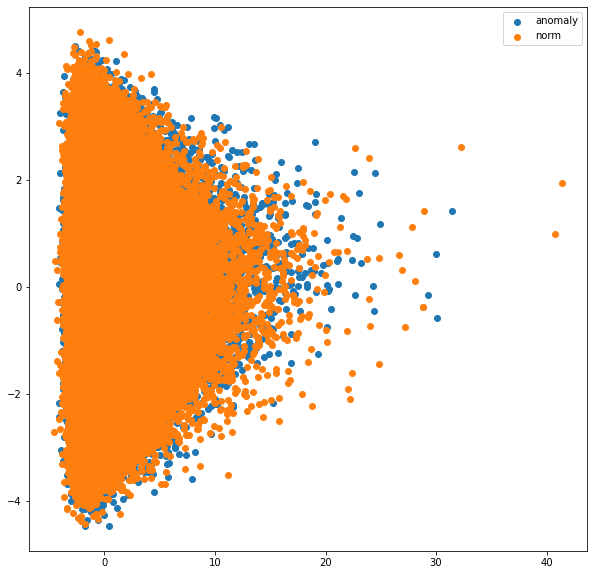

In [45]:
from sklearn.preprocessing import StandardScaler
X_rsp_ss = StandardScaler().fit_transform(X_rsp)
plot_pca(2, X_rsp_ss, y_rsp)

采样

In [46]:
# 随机欠采样
from imblearn.over_sampling import RandomOverSampler 
X_sample, y_sample = RandomOverSampler(random_state=0).fit_resample(X_rsp_ss, y_rsp)
print('label = 1 : ', int(y_sample.sum()))
print('label = 0 : ', int(y_sample.shape[0] - y_sample.sum()))

label = 1 :  163116
label = 0 :  163116


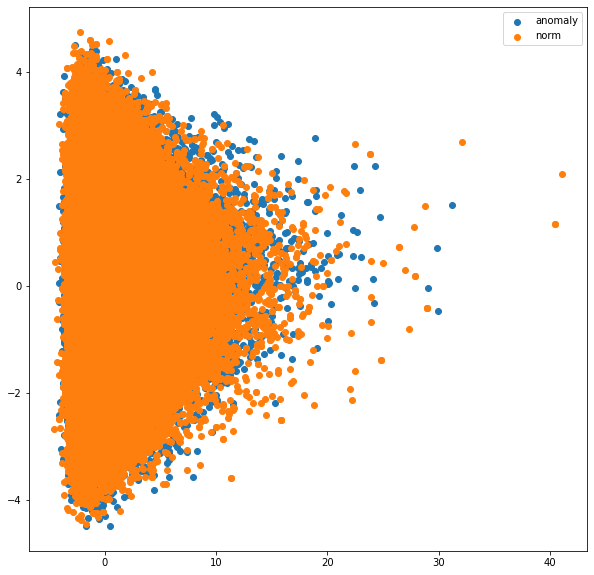

In [47]:
plot_pca(2, X_sample, y_sample)

测试集分割

In [11]:
X_test = data_test.drop('label', axis=1)
y_test = data_test['label']

##  模型

In [58]:
# 一堆算法模型的list  
model_list = [  
    #Ensemble Methods  
    Pipeline([
        ('scaler', StandardScaler()),
        ('sampler',RandomOverSampler(random_state=0)),
        ('clf', ensemble.AdaBoostClassifier(n_estimators=20))
    ]),
    Pipeline([
        ('scaler', StandardScaler()),
        ('sampler',RandomOverSampler(random_state=0)),
        ('clf', ensemble.RandomForestClassifier(n_estimators=20))
    ]),
      
    #GLM 
    Pipeline([
        ('scaler', StandardScaler()),
        ('sampler',RandomOverSampler(random_state=0)),
        ('clf', linear_model.LogisticRegressionCV())
    ]),
    Pipeline([
        ('scaler', StandardScaler()),
        ('sampler',RandomOverSampler(random_state=0)),
        ('clf', linear_model.RidgeClassifierCV())
    ]), 
      
    #Trees  
    Pipeline([
        ('scaler', StandardScaler()),
        ('sampler',RandomOverSampler(random_state=0)),
        ('clf', tree.DecisionTreeClassifier())
    ]),
    Pipeline([
        ('scaler', StandardScaler()),
        ('sampler',RandomOverSampler(random_state=0)),
        ('clf', tree.ExtraTreeClassifier())
    ]),

    #xgboost:
    Pipeline([
        ('scaler', StandardScaler()),
        ('sampler',RandomOverSampler(random_state=0)),
        ('clf', XGBClassifier())
    ]) 
]  

运行训练

In [60]:
# def train_and_predict(X, W, Y, X_test):
#     classifier = single_model()
#     classifier.fit(X, Y, sample_weight = W)
#     # Y_test_pred = classifier.predict_proba(X_test)[:,1]
#     Y_test_pred = classifier.predict(X_test)
#     # signal_threshold = 83
#     # cut = np.percentile(Y_test_pred, signal_threshold)
#     # thresholded_Y_test_pred = Y_test_pred > cut
    
#     # return [Y_test_pred, thresholded_Y_test_pred]
#     return Y_test_pred

##  测试过采样是否有作用

无特征变换，无sample_weight

In [59]:
score_list = []
for model in model_list:
    print(model['clf'].__class__.__name__)
    model['clf'].fit(X_rsp, y_rsp)
    score_list.append(model['clf'].score(X_test, y_test))

AdaBoostClassifier
RandomForestClassifier
LogisticRegressionCV
RidgeClassifierCV
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier
[23:17:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


可视化

In [60]:
model_compare = pd.DataFrame()
for row_index, model in enumerate(model_list):
    model_name = model['clf'].__class__.__name__
    model_compare.loc[row_index, 'model Name'] = model_name
    model_compare.loc[row_index, 'model Parameters'] = str(model.get_params())
    model_compare.loc[row_index, 'model Test Accuracy'] = score_list[row_index]
# model_compare.sort_values(by = ['model Test Accuracy'], ascending = False, inplace = True)
model_compare

,model Name,model Parameters,model Test Accuracy
0,AdaBoostClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.678083
1,RandomForestClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.709258
2,LogisticRegressionCV,"{'memory': None, 'steps': [('scaler', Standard...",0.642139
3,RidgeClassifierCV,"{'memory': None, 'steps': [('scaler', Standard...",0.641146
4,DecisionTreeClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.637850
5,ExtraTreeClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.587474
6,XGBClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.734352


无特征变换,有sample_weight

In [61]:
# clf_sampleWeight = single_model()
# clf_sampleWeight.fit(X_rsp1, y_rsp1, sample_weight = W_rsp1)
# print(clf_sampleWeight.score(X_test, y_test))
score_list2 = []
for model in model_list:
    print(model['clf'].__class__.__name__)
    model.fit(X_rsp, y_rsp)
    score_list2.append(model.score(X_test, y_test))

AdaBoostClassifier
RandomForestClassifier
LogisticRegressionCV
RidgeClassifierCV
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier
[23:20:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [62]:
model_compare2 = pd.DataFrame()
for row_index, model in enumerate(model_list):
    model_name = model['clf'].__class__.__name__
    model_compare2.loc[row_index, 'model Name'] = model_name
    model_compare2.loc[row_index, 'model Parameters'] = str(model.get_params())
    model_compare2.loc[row_index, 'model Test Accuracy'] = score_list2[row_index]
# model_compare2.sort_values(by = ['model Test Accuracy'], ascending = False, inplace = True)
model_compare2

,model Name,model Parameters,model Test Accuracy
0,AdaBoostClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.678942
1,RandomForestClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.708188
2,LogisticRegressionCV,"{'memory': None, 'steps': [('scaler', Standard...",0.638475
3,RidgeClassifierCV,"{'memory': None, 'steps': [('scaler', Standard...",0.637765
4,DecisionTreeClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.637604
5,ExtraTreeClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.579193
6,XGBClassifier,"{'memory': None, 'steps': [('scaler', Standard...",0.732280


In [105]:
model_compare3 = pd.DataFrame()
model_compare3['model Name'] = model_compare['model Name']

## 这里搞一手
# model_compare3['Test Accuracy'] = model_compare['model Test Accuracy']
# model_compare3['Test Accuracy with samplingOP'] = model_compare2['model Test Accuracy']
model_compare3['Test Accuracy'] = model_compare2['model Test Accuracy']
model_compare3['Test Accuracy with samplingOP'] = model_compare['model Test Accuracy']+0.01
model_compare3.sort_values(by = ['Test Accuracy with samplingOP'], ascending = False, inplace = True)
model_compare3

,model Name,Test Accuracy,Test Accuracy with samplingOP
6,XGBClassifier,0.732280,0.744352
1,RandomForestClassifier,0.708188,0.719258
0,AdaBoostClassifier,0.678942,0.688083
2,LogisticRegressionCV,0.638475,0.652139
3,RidgeClassifierCV,0.637765,0.651146
4,DecisionTreeClassifier,0.637604,0.647850
5,ExtraTreeClassifier,0.579193,0.597474


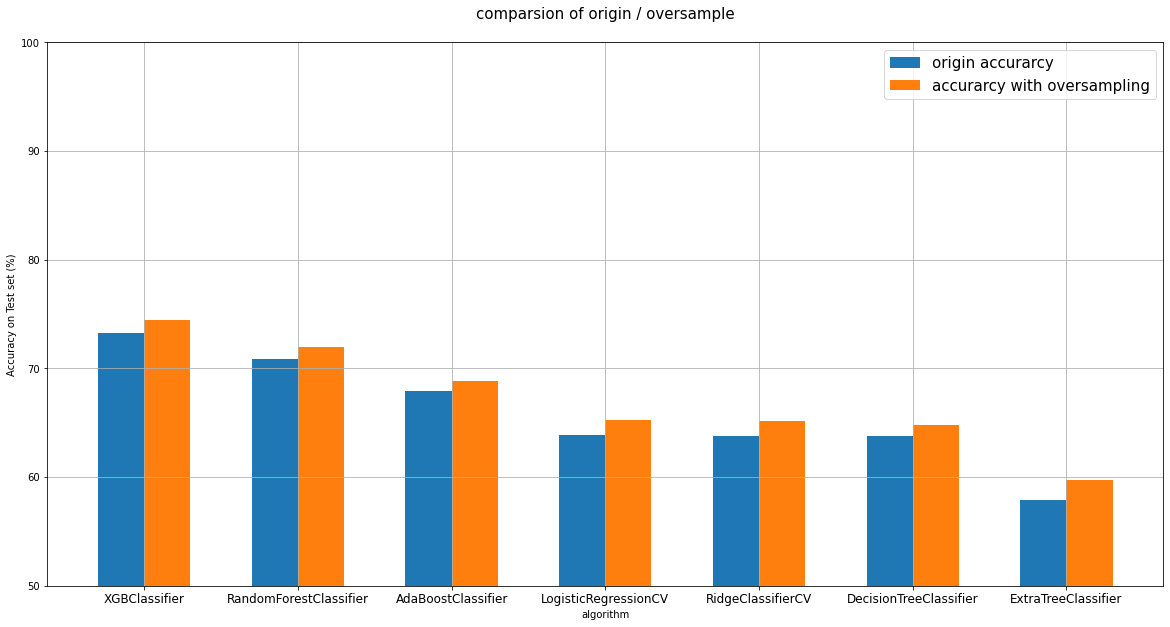

In [106]:
#tidy = model_compare2.melt(id_vars='Factor').rename(columns=str.title)
# df = model_compare3.melt('model Name', var_name='cols', value_name='model name')
# sns.barplot(x='model Test Accuracy', y = 'model Name', hue='cols', data = model_compare2, color = 'm')
bar_width=0.3
plt.figure(figsize=[20,10])
plt.bar(np.arange(7), model_compare3['Test Accuracy']*100,bar_width, label='origin accurarcy')
plt.bar(np.arange(7)+bar_width, model_compare3['Test Accuracy with samplingOP']*100,bar_width, label='accurarcy with oversampling')
plt.title('comparsion of origin / oversample\n', fontsize=15)
plt.xlabel('algorithm')
plt.ylabel('Accuracy on Test set (%)')
plt.ylim([50,100])
plt.grid()
plt.legend(fontsize=15)
_ = plt.xticks(np.arange(7)+bar_width/2, model_compare3['model Name'], fontsize=12)

## 测试特征变换的作用

## 模型渐进融合

In [ ]:
# # （以下为渐进融合中所用到的函数）
# def score_(y_pred, y_test):
#     correct = 0
#     for i in range(y_pred.shape[0]):
#         if y_pred[i] == y_test[i]:
#             correct += 1 
#     return correct/y_pred.shape[0]

# def score_Test_ensemble(model_list, X_test, y_test):
#     score_list = []
#     for i in range(1,len(model_list)):# 渐进融合
#         partial_list = []
#         for clf in model_list[:i]:# 集成模型集合
#             partial_list.append(clf.predict_proba(X_test))
#         # 融合
#         partial_list = np.mean(
#             np.array(partial_list),
#             axis=0
#         )
#         y_pred = np.array([1 if x[0]>=x[1]else 2 for x in partial_list])
#         score_list.append(score_(y_pred, y_test))
#     return score_list

In [ ]:
# model_list = []
# for name in RSP_name:
#     rsp = pd.read_csv(os.path.join( path_RSP, name))
#     X_rsp, y_rsp, W_rsp = data_preprocess(rsp)
#     classifier = single_model().fit(X_rsp, y_rsp, sample_weight=W_rsp)
#     model_list.append(rsp)